# Homework 06 - Convolutional Neural Networks

In this homework you will implement a convolutional neural network to solve a object recognition task. The dataset you will work with is the CIFAR10 dataset, which contains small RGB images for ten different classes. 
 
To learn how you implement neural networks on your own I will only give minimal supervision, but you can get a lot of help from the last homework.

In [0]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


### Investigate the dataset.

Q: *How many training/test images does this dataset have?*  
A: 50000 Training, 10000 Test

Q: *Which shape does one image have?*  
A: 32 by 32 pixels plus 3 color channels each

Q: *In which range are the pixel values?*  
A: 0 to 255

In [0]:
print(train_images.shape, test_images.shape)
np.ptp(train_images[0])


(50000, 32, 32, 3) (10000, 32, 32, 3)


255

#### Have a look at some images from the dataset.

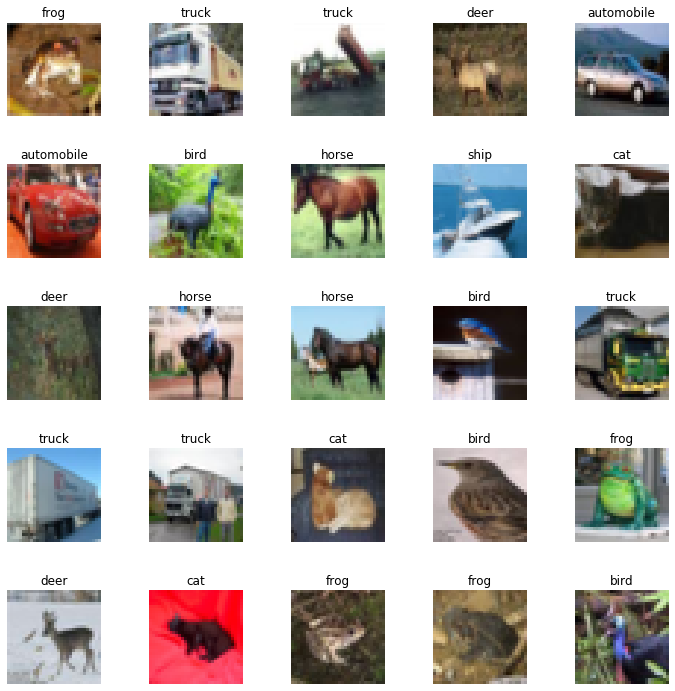

In [0]:
label_words = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

fig, ax = plt.subplots(5,5,figsize=(10,10))
fig.tight_layout()
ax = ax.flatten()
for i in range(25):
    # Readout the first 25 images and the corresponding labels.
    img = train_images[i]
    lbl = label_words[train_labels[i][0]]
    ######################
    ax[i].imshow(img, cmap='gray')
    ax[i].set_title(lbl)
    ax[i].axis("off")

### Prepare the TensorFlow dataset.

In [0]:
# Adjust the data format of the input
train_images = np.array(train_images, dtype=np.float32)
test_images = np.array(test_images, dtype=np.float32)
train_images, test_images = train_images / 255.0, test_images / 255.0
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffle the training dataset.
train_dataset = train_dataset.shuffle(buffer_size=60000)
# Use a batchsize of 32 for the training dataset.
train_dataset = train_dataset.batch(32)
# Use full batch for the test dataset/
test_dataset = test_dataset.batch(10000)

### Build the model.

In [0]:
from tensorflow.keras.layers import Layer

class Model(Layer):
    
    def __init__(self):
        super(Model, self).__init__()
        # Initialize all layers.   

        # Convolutional layer: 32 kernels of size (3,3) with ReLU activation function (tf.keras.activations.relu), input shape given in first layer
        self.one = tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3),
                                           activation= 'relu',
                                           input_shape=(32, 32, 3))
        # Maxpooling layer: pooling size (2,2) and strides (2,2).
        self.two = tf.keras.layers.MaxPool2D(pool_size = (2,2),
                                             strides = (2,2))
        # Convolutional layer: 64 kernels of size (3,3) with ReLU activation function 
        self.three = tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3),
                                           activation= 'relu')
        # Maxpooling layer: pooling size (2,2) and strides (2,2).
        self.four = tf.keras.layers.MaxPool2D(pool_size = (2,2),
                                              strides = (2,2))
        # Convolutional layer: 64 kernels of size (3,3) with ReLU activation function
        self.five = tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3),
                                            activation= 'relu')
        # Flatten the resulting feature maps.
        self.six = tf.keras.layers.Flatten()
        # Fully connected layer with 64 hidden neurons and ReLU activation function.
        self.seven = tf.keras.layers.Dense(units= 64, 
                                         activation= 'relu')
        # Fully connected layer with 10 output neurons and softmax activation function (tf.keras.activations.softmax).
        self.out = tf.keras.layers.Dense(units= 10, 
                                         activation= tf.keras.activations.softmax)
        
    def call(self, x):
        # Calling the layers after each other
        x = self.one(x)
        x = self.two(x)
        x = self.three(x)
        x = self.four(x)
        x = self.five(x)
        x = self.six(x)
        x = self.seven(x)
        x = self.out(x)
        return x

### Train the model.

In [0]:
tf.keras.backend.clear_session()

# Instantiate Model
model = Model()

# Defining loss function as categorical crossentropy
cce = tf.keras.losses.CategoricalCrossentropy()
loss = cce

# Define optimizer as adam with default parameters
optimizer = tf.keras.optimizers.Adam() # standard parameters: learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,

# Initialize lists for later visualiztion
train_steps = []
train_losses = []
train_accuracies = []
test_steps = []
test_losses = []
test_accuracies = []
loss_steps = []
step = 0


for epoch in range(3):
    
    for (x,t) in train_dataset:

        # Turn the labels into one-hot vectors.
        t = tf.reshape(t, shape=[-1])
        t = tf.one_hot(t, depth = 10)
        
        # Perform a training step.
        # Compute the output, loss and the gradients.
        with tf.GradientTape() as tape:
            output = model(x)
            train_loss = loss(t, output)
            gradients = tape.gradient(train_loss, model.trainable_variables)
        
        # After recording the gradients we can apply them to the 
        # variables.
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # Store loss
        train_losses.append(train_loss)
        loss_steps.append(step)
        
        # Calculate the training accuracy every 25 steps.
        if step % 25 == 0:
            # Compute the accuracy.
            acc = tf.keras.metrics.CategoricalAccuracy( name='acc')
            acc.update_state(t, output)
            accuracy = acc.result().numpy()

            # save for later visualisation
            train_accuracies.append(accuracy)
            train_steps.append(step)
                
        # Calculate the test loss and accuracy every 50 steps.
        if step % 50 == 0:
            for (x,t) in test_dataset:
                # first compute output of the network for the test data
                t = tf.reshape(t, shape=[-1])
                t = tf.one_hot(t, depth = 10)
                output = model(x)

                # then compute loss and accuracy
                test_loss = loss(t, output)
                acc = tf.keras.metrics.CategoricalAccuracy( name='acc')
                acc.update_state(t, output)
                accuracy = acc.result().numpy()

                # save for later visualisation
                test_steps.append(step)
                test_accuracies.append(accuracy)
                test_losses.append(test_loss)
        

        step += 1

### Visualize the training progress.

Your model should achieve around 60-70% test accuracy.

Final Training Loss:  1.1593144
Final Test Loss:  0.9980541
Final Training Accuracy:  0.78125
Final Test Accuracy:  0.6566
Best Test Accuracy:  0.6646


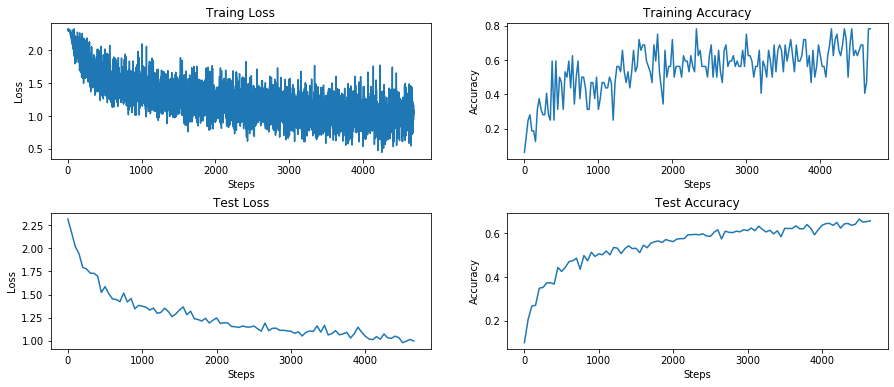

In [0]:
# final scores
print('Final Training Loss: ',np.array(train_losses[-1]))
print('Final Test Loss: ',np.array(test_losses[-1]))
print('Final Training Accuracy: ',np.array(train_accuracies[-1]))
print('Final Test Accuracy: ',np.array(test_accuracies[-1]))
print('Best Test Accuracy: ',np.max(np.array(test_accuracies)))


# training loss graph
fig = plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace = 0.4)
a=fig.add_subplot(2,2,1)
# training loss
plt.plot(loss_steps, np.array(train_losses))
plt.title('Traing Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")

# training accuracy graph
a=fig.add_subplot(2,2,2)
# training accuracy
plt.plot(train_steps, np.array(train_accuracies))
plt.title('Training Accuracy')
plt.xlabel("Steps")
plt.ylabel("Accuracy")

# test loss graph
a=fig.add_subplot(2,2,3)
# testing loss
plt.plot(test_steps, np.array(test_losses))
plt.title('Test Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")

# test accuracy graph
a=fig.add_subplot(2,2,4)
# test accuracy
plt.plot(test_steps, np.array(test_accuracies))
plt.title('Test Accuracy')
plt.xlabel("Steps")
plt.ylabel("Accuracy")

plt.show()